# Denoising Diffusion Probabilistic Models (DDPM)

The theoretical basics and implementations of DDPM.

Written by Junkun Yuan (yuanjk0921@outlook.com).

Last updated on June 16, 2025; &nbsp; First committed on March 9, 2025.

See more reading papers and notes [here](https://junkunyuan.github.io/paper_reading_list/htmls/paper_reading_list.html).

**References**
- [**Denoising Diffusion Probabilistic Models** *(NeurIPS 2020)*](https://arxiv.org/pdf/2006.11239): The paper which proposes the DDPM algorithm.
- [**Understanding Diffusion Models: A Unified Perspective** *(arXiv 2022)*](https://arxiv.org/pdf/2208.11970): A theoretical introduction to diffusion models and other generative models.

**Contents**
- Preliminary
- Variational Autoencoder (VAE)
- Denoising Diffusion Probabilistic Models (DDPM)
    - Diffusion Process / Forward Process
    - Denoising Process / Reverse Process
    - PyTorch Implementations

## Preliminary

**What are generative models?** They are designed to <u>model true data distributions $p(\boldsymbol{x})$</u>, so that one can use them to generate new data.

**How to model $p(\boldsymbol{x})$?** We <u>maximize likelihood</u> of the observed data. 

Here, the [**likelihood**](https://en.wikipedia.org/wiki/Likelihood_function) measures how well a model explains the observed data by calculating <u>the probability of seeing that data</u> under different parameter values of the model. For example, likelihood function $p(\boldsymbol{x}|\theta)$ is a function of $\theta$.

**How to estimate likelihood?**

We assume <u>$\boldsymbol{x}$ is generated by some latent variable $\boldsymbol{z}$</u>, then we have

- *Approach (1):* $p(\boldsymbol{x})=\int p(\boldsymbol{x}, \boldsymbol{z})d\boldsymbol{z}$;
- *Approach (2):* $p(\boldsymbol{x})=\frac{p(\boldsymbol{x}, \boldsymbol{z})}{p(\boldsymbol{z}|\boldsymbol{x})}$.

However, approach (1) needs to integrate out the latent variable $\boldsymbol{z}$; approach (2) needs to access to the unknown $p(\boldsymbol{z}|\boldsymbol{x})$.

[**Evidence (marginal likelihood)**](https://en.wikipedia.org/wiki/Marginal_likelihood) is a likelihood that has been integrated over the space of some parameters $\phi$.

Let we have an approximate variational distribution $q_\phi(\boldsymbol{z}|\boldsymbol{x})$, we have the ELBO given below.

**Evidence Lower Bound (ELBO):** <u>the lower bound of the evidence</u>. We give its formulation and prove it: 
<font color=red>
$$\mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}[\log\frac{p(\boldsymbol{x},\boldsymbol{z})}{q_\phi(\boldsymbol{z}|\boldsymbol{x})}].$$
</font>

*Proof using approach (1) (based on [Jensen’s inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality)):*
\begin{equation}
\begin{aligned}
    \log p(\boldsymbol{x}) 
    =& \log \int p(\boldsymbol{x}, \boldsymbol{z})d\boldsymbol{z} \\
    =& \log \mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}\frac{p(\boldsymbol{x},\boldsymbol{z})}{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})} \\
    \ge& \mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}[\log\frac{p(\boldsymbol{x},\boldsymbol{z})}{q_\phi(\boldsymbol{z}|\boldsymbol{x})}] \ \ \ \text{(Jensen’s inequality)}.
\end{aligned}
\end{equation}

*Proof using approach (2):*
\begin{equation}
\begin{aligned}
\log p(\boldsymbol{x})
=&\log p(\boldsymbol{x}) \int q_{\phi}(\boldsymbol{z}|\boldsymbol{x}) d\boldsymbol{z} \\
=&\mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})} [\log p(\boldsymbol{x})] \\
=&\mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})} [\log \frac{p(\boldsymbol{x}, \boldsymbol{z})}{p(\boldsymbol{z}|\boldsymbol{x})}] \\
=&\mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})} [\log \frac{p(\boldsymbol{x}, \boldsymbol{z})}{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}] + \underbrace{\mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})} [\log \frac{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}{p(\boldsymbol{z}|\boldsymbol{x})}]}_{D_{\mathrm{KL}}(q_{\phi}(\boldsymbol{z}|\boldsymbol{x})||p(\boldsymbol{z}|\boldsymbol{x}))\ge0} \\
\ge& \mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}[\log\frac{p(\boldsymbol{x},\boldsymbol{z})}{q_\phi(\boldsymbol{z}|\boldsymbol{x})}].
\end{aligned}
\end{equation}

As we know, solving approach (2) needs to access to $p(\boldsymbol{z}|\boldsymbol{x})$. <font color=red>*As $\log p(\boldsymbol{x})$ is a constant, thus <u>maximizing ELBO</u> can be a proxy for modeling $p(\boldsymbol{z}|\boldsymbol{x})$ using $q_\phi(\boldsymbol{z}|\boldsymbol{x})$ by minimizing their KL divergence.</font>

## Variational Autoencoder (VAE)

We begin by dissecting the ELBO further:

<font color=red>

$$
\mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}[\log\frac{p(\boldsymbol{x},\boldsymbol{z})}{q_\phi(\boldsymbol{z}|\boldsymbol{x})}]
=\underbrace{\mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}[\log p_{\theta}(\boldsymbol{x}|\boldsymbol{z})]}_{\text{reconstruction term}} - \underbrace{-(\mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}[\log\frac{p(\boldsymbol{z})}{q_\phi(\boldsymbol{z}|\boldsymbol{x})}])}_{D_{\mathrm{KL}}(q_\phi(\boldsymbol{z}|\boldsymbol{x})||p(\boldsymbol{z})), \ \ \text{prior matching term}}.
$$

</font>
    
Therefore, maximizing ELBO is equivalent to optimize an encoder with parameters $\phi$ and a decoder with parameters $\theta$ by
- <font color=red>**Prior matching term:** optimizing an **encoder** of $q_{\phi}(\boldsymbol{z}|\boldsymbol{x})$ to embed data $\boldsymbol{x}$  to match a prior latent distribution $p(\boldsymbol{z})$;</font>
- <font color=red>**Reconstruction term:** optimizing a **decoder** of $p_{\theta}(\boldsymbol{x}|\boldsymbol{z})$ to convert latents $\boldsymbol{z}$ back to data $\boldsymbol{x}$.</font>

**How to optimize $\phi$ and $\theta$ by modeling and sampling from the variational distribution?**

**[Reparameterization trick](https://en.wikipedia.org/wiki/Reparameterization_trick):** samples from a Gaussian distribution $\boldsymbol{x}\sim\mathcal{N}(\boldsymbol{x};\boldsymbol{\mu},\boldsymbol{\sigma}^2)$ can be rewritten as:

$$
\boldsymbol{x}=\boldsymbol{\mu}+\boldsymbol{\sigma}\boldsymbol{\epsilon} \ \ \text{where } \boldsymbol{\epsilon}\sim\mathcal{N}(\boldsymbol{\epsilon};\mathbf{0}, \mathbf{I}).
$$

It rewrites a random variable as a deterministic function of a noise variable to allow for optimizing non-stochastic terms through gradient descent.
Let

$$
q_\phi(\boldsymbol{z}|\boldsymbol{x})=\mathcal{N}(\boldsymbol{z};\boldsymbol{\mu}_{\phi}(\boldsymbol{x}),\boldsymbol{\sigma}^2_{\phi}(\boldsymbol{x})\mathbf{I}), \ \ p(\boldsymbol{z})=\mathcal{N}(\boldsymbol{z};\mathbf{0},\mathbf{I}),
$$

we then have another formula of the latent $\boldsymbol{z}$ ($\odot$ represents an element-wise product)
$$
\boldsymbol{z}=\boldsymbol{\mu}_{\phi}(\boldsymbol{x})+\boldsymbol{\sigma}_{\phi}(\boldsymbol{x})\odot\boldsymbol{\epsilon} \ \text{ where } \boldsymbol{\epsilon}\sim\mathcal{N}(\boldsymbol{\epsilon};\mathbf{0},\mathbf{I}).
$$

VAE utilizes the reparaterization trick and [Monte Carlo estimate](https://en.wikipedia.org/wiki/Monte_Carlo_method) to optimize the ELBO jointly over $\phi$ and $\theta$.

## Denoising Diffusion Probabilistic Models (DDPM)

### Diffusion Process / Forward Process

**Diffusion process** is a process of transforming a <u>data distribution</u> of $p_{\mathrm{data}}$ into a <u>prior/simple distribution</u> of $p_{\text{prior}}$.

**Diffusion model** is a probability distribution transformation model $\mathcal{T}$, transforming $p_{\mathrm{data}}$ of <u>raw data</u> $\boldsymbol{x}_0$ into $p_{\text{prior}}$:

$$\boldsymbol{x}_0 \sim p_{\text{data}} \rightarrow \mathcal{T}(\boldsymbol{x}_0)\sim p_{\text{prior}}.$$

[**Markov chain**](https://en.wikipedia.org/wiki/Markov_chain) is an approach to <u>perform the diffusion process</u> through conditional probability $q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$, converting $\boldsymbol{x}_0$ to $\boldsymbol{x}_1$, $\boldsymbol{x}_2$, ..., $\boldsymbol{x}_T$ in sequence, hoping that when $T \rightarrow \inf$, then $\boldsymbol{x}_T\sim p_{\text{prior}}$. 

Let $p_{\text{prior}}$ be the standard Gaussian distribution, we have

$$q(\boldsymbol{x}_T):=p_{\text{prior}}(\boldsymbol{x}_T)=\mathcal{N}(\boldsymbol{x}_{T};\mathbf{0},\mathbf{I}) \ \ \text{when } T\rightarrow\inf.$$

**How to achieve the diffusion process using Markov chain?**

We begin by directly giving the formulation of <u>diffusion process (forward process)</u>:

<font color=red>

$$
    q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0):= \prod_{t=1}^{T} q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1}), \quad
    q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1}):= \mathcal{N}(\boldsymbol{x}_t;\sqrt{1-\beta_t}\boldsymbol{x}_{t-1},\beta_t\mathbf{I}). \quad \text{[Eq. (2) of the DDPM paper]}
$$

</font>

Based on the <u>reparameterization trick</u>, we have:

$$
\boldsymbol{x}_t=\sqrt{1-\beta_t}\boldsymbol{x}_{t-1}+\sqrt{\beta_t}\boldsymbol{\epsilon}_{t-1} \ \text{ where } \boldsymbol{\epsilon}_{t-1} \sim \mathcal{N}(\boldsymbol{\epsilon}_{t-1};\mathbf{0},\mathbf{I}).
$$

Since $(\sqrt{1-\beta_t})^2 + \sqrt{\beta_t}^2 = 1$, we find that <font color=red>the diffusion process can be seen as continuing <u>adding noise</u> $\boldsymbol{\epsilon}$ to data $\boldsymbol{x}$ with <u>variance-preserving</u>, where <u>variance schedule</u> $\beta_t$ controls the <u>ratio</u> of adding noise</font>.

**Can we directly reach $\boldsymbol{x}_t$ from $\boldsymbol{x}_0$?**

Let $\alpha_t:=1-\beta_t$ and $\bar{\alpha}_t=\prod_{s=1}^{t}\alpha_s$, we have (each noise "$\boldsymbol{\epsilon}$" follows $\mathcal{N}(\boldsymbol{\epsilon};\mathbf{0},\mathbf{I})$ below)

\begin{equation}
\begin{aligned}
\boldsymbol{x}_t=&\sqrt{\alpha_t}\boldsymbol{x}_{t-1}+\sqrt{1-\alpha_t}\boldsymbol{\epsilon}_{t-1} \\
=&\sqrt{\alpha_t\alpha_{t-1}}\boldsymbol{x}_{t-2}+\sqrt{\alpha_t(1-\alpha_{t-1})}\boldsymbol{\epsilon}_{t-2}+\sqrt{1-\alpha_t}\boldsymbol{\epsilon}_{t-1} \\
=&\sqrt{\alpha_t\alpha_{t-1}}\boldsymbol{x}_{t-2}+\sqrt{1-\alpha_t\alpha_{t-1}}\hat{\boldsymbol{\epsilon}}_{t-2} \\
&... \\
=&\sqrt{\bar{\alpha}_{t}}\boldsymbol{x}_0+\sqrt{1-\bar{\alpha}_{t}}\boldsymbol{\epsilon}.
\end{aligned}
\end{equation}

<font color=red>

$$
q(\boldsymbol{x}_t|\boldsymbol{x}_{0})=\mathcal{N}(\boldsymbol{x}_t;\sqrt{\bar{\alpha}_t}\boldsymbol{x}_0,(1-\bar{\alpha}_t)\mathbf{I}) \quad \text{[Eq. (4) of the DDPM paper]}.
$$

</font>

If $\beta_t\in(0,1)$, then $\alpha_t\in(0,1)$. When $T\rightarrow\inf$, $\bar{\alpha}_T\rightarrow0$ and $q(\boldsymbol{x}_{T})=p_{\text{prior}}(\boldsymbol{x}_{T})=\mathcal{N}(\mathbf{0}, \mathbf{I})$, satisifying the diffusion goal.

**[Remark]** Diffusion models can be seen as <u>markovian hierarchical variational autoencoders with three restrictions</u>:
- The latent dimension is exactly equal to the data dimension;
- The structure of the latent encoder is not learned, but pre-defined as a linear Gaussian model;
- The Gaussian parameters of the latent encoders vary over time in such a way that the distribution of the latent at final timestep $T$ is a standard Gaussian.

### Denoising Process / Reverse Process

**Denoising process** transforms $p_{\mathrm{prior}}$/$p(\boldsymbol{x}_T)$ back to $p_{\mathrm{data}}$/$p(\boldsymbol{x}_0)$ through <u>variational distribution</u> $p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t)$.

Similar to VAE, we maximize the likelihood:

\begin{equation}
\begin{aligned}
&\log p(\boldsymbol{x}_0)\\
=&\log(\int{p(\boldsymbol{x}_{0:T})d\boldsymbol{x}_{1:T}}) \\
=&\log\mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)}[\frac{p(\boldsymbol{x}_{0:T})}{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)}] \\
\geq&\mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)}[\log{ \frac{p(\boldsymbol{x}_{0:T})}{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)}}] \ \ (\text{Jensen's inequality}) \\
=& \mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)} [\log{ \frac{p(\boldsymbol{x}_{T})p_{\theta}(\boldsymbol{x}_{0}|\boldsymbol{x}_{1})\prod_{t=1}^{T-1}p_{\theta}(\boldsymbol{x}_{t}|\boldsymbol{x}_{t+1})}{q(\boldsymbol{x}_{T}|\boldsymbol{x}_{T-1})\prod_{t=1}^{T-1}q(\boldsymbol{x}_{t}|\boldsymbol{x}_{t-1})}}] \\
=& \underbrace{\mathbb{E}_{q(\boldsymbol{x}_{1}|\boldsymbol{x}_0)} [\log p_{\theta}(\boldsymbol{x}_{0}|\boldsymbol{x}_{1})]}_{\text{reconstruction term}} - \underbrace{(-\mathbb{E}_{q(\boldsymbol{x}_{T-1}|\boldsymbol{x}_0)} [\log \frac{p(\boldsymbol{x}_{T})}{q(\boldsymbol{x}_{T}|\boldsymbol{x}_{T-1})}])}_{\text{prior matching term: } \mathbb{E}_{q(\boldsymbol{x}_{T-1}|\boldsymbol{x}_0)} [D_{\mathrm{KL}}(q(\boldsymbol{x}_{T}|\boldsymbol{x}_{T-1}) || p(\boldsymbol{x}_{T}))]} - \underbrace{(-\sum_{t=1}^{T-1}\mathbb{E}_{q(\boldsymbol{x}_{t-1},\boldsymbol{x}_{t+1}|\boldsymbol{x}_0)} [\log\frac{p_{\theta}(\boldsymbol{x}_{t}|\boldsymbol{x}_{t+1})}{q(\boldsymbol{x}_{t}|\boldsymbol{x}_{t-1})}])}_{\text{consistency term:} D_{\mathrm{KL}}(q(\boldsymbol{x}_{t}|\boldsymbol{x}_{t-1}) || p_{\theta}(\boldsymbol{x}_{t}|\boldsymbol{x}_{t+1}))}
\end{aligned}
\end{equation}

- **Prior matching term:** matching the final latent to Gaussian prior;
- **Reconstruction term:** predicting original data given the first-step latent;
- **Consistency term:** making the distribution at $\boldsymbol{x}_t$ consistent from both the diffusion and the denoising processes.

However, the consistency term is computed as an expectation over *two random variables* (i.e., ${\boldsymbol{x}_{t-1}}$ and $\boldsymbol{x}_{t+1}$) for every timestep, <u>the variance of its Monte Carlo estimate could potentially be higher than estimating just one variable</u>. 

We start to derive the formula from another perspective:

\begin{equation}
\begin{aligned}
&\log p(\boldsymbol{x}_0)\\
=&\log(\int{p(\boldsymbol{x}_{0:T})d\boldsymbol{x}_{1:T}}) \\
=&\log\mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)}[\frac{p(\boldsymbol{x}_{0:T})}{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)}] \\
\geq&\mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)}[\log{ \frac{p(\boldsymbol{x}_{0:T})}{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)}}] \ \ (\text{Jensen's inequality}) \\
=& \mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)} [\log p(\boldsymbol{x}_{T}) + \sum_{t=1}^T\log{ \frac{p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})}{q(\boldsymbol{x}_{t}|\boldsymbol{x}_{t-1})}}] \quad \text{[Eq. (3) of the DDPM paper]} \\
=& \mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)} [\log p(\boldsymbol{x}_{T}) + \sum_{t=2}^T\log{ \frac{p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})}{q(\boldsymbol{x}_{t}|\boldsymbol{x}_{t-1})}} + \log{ \frac{p_{\theta}(\boldsymbol{x}_{0}|\boldsymbol{x}_{1})}{q(\boldsymbol{x}_{1}|\boldsymbol{x}_{0})}}] \\
=& \mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)} [\log p(\boldsymbol{x}_{T}) + \sum_{t=2}^T\log{ \frac{p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})}{q(\boldsymbol{x}_{t}|\boldsymbol{x}_{t-1}, \boldsymbol{x}_0)}} + \log{ \frac{p_{\theta}(\boldsymbol{x}_{0}|\boldsymbol{x}_{1})}{q(\boldsymbol{x}_{1}|\boldsymbol{x}_{0})}}] \ \ (\text{property of Markov chain}) \\
=& \mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)} [\log p(\boldsymbol{x}_{T}) + \sum_{t=2}^T\log{ \frac{p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})}{q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_0)} + \sum_{t=2}^T\log \frac{q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_0)}{q(\boldsymbol{x}_{t}|\boldsymbol{x}_{0})}} + \log{ \frac{p_{\theta}(\boldsymbol{x}_{0}|\boldsymbol{x}_{1})}{q(\boldsymbol{x}_{1}|\boldsymbol{x}_{0})}}] \ (\text{Baye's theorem}) \\
=& \mathbb{E}_{q(\boldsymbol{x}_{1:T}|\boldsymbol{x}_0)} [\log p(\boldsymbol{x}_{T}) + \sum_{t=2}^T\log{ \frac{p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})}{q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_0)} + \log \frac{q(\boldsymbol{x}_{1}|\boldsymbol{x}_0)}{q(\boldsymbol{x}_{T}|\boldsymbol{x}_{0})}} + \log{ \frac{p_{\theta}(\boldsymbol{x}_{0}|\boldsymbol{x}_{1})}{q(\boldsymbol{x}_{1}|\boldsymbol{x}_{0})}}] \\
=& \textcolor{#FF0000}{\mathbb{E}_{q(\boldsymbol{x}_{1}|\boldsymbol{x}_0)} [\underbrace{\log p_\theta(\boldsymbol{x}_{0}|\boldsymbol{x}_1)}_{\text{reconstruction term}}] - \sum_{t=2}^T\mathbb{E}_{q(\boldsymbol{x}_{t}|\boldsymbol{x}_0)}[\underbrace{D_{\mathrm{KL}}(q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_0)||p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t}))}_{\text{denoising matching term}}]} \\
&\textcolor{#FF0000}{- \mathbb{E}_{q(\boldsymbol{x}_{T}|\boldsymbol{x}_0)}[\underbrace{D_{\mathrm{KL} }(q(\boldsymbol{x}_T|\boldsymbol{x}_0)||p(\boldsymbol{x}_{T}))}_{\text{prior matching term}}] \quad \text{[Eq. (5) of the DDPM paper]}}.
\end{aligned}
\end{equation}

- **Prior matching term:** matching the final latent to Gaussian prior;
- **Reconstruction term:** predicting original data given the first-step latent;
- **Denoising matching term:** defining how to denoise with the access to $\boldsymbol{x}_0$.

When we set $T=1$, it is the same as the formulation of VAE (since they are both derived from Markov chain).

**Minimizing the denoising matching term by aligning $p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})$ to $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_0)$.**

**What is $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_0)$?** It can be found as a Gaussian distribution by

\begin{equation}
\begin{aligned}
&q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t},\boldsymbol{x}_0)\\
=&q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1},\boldsymbol{x}_0)\frac{q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{0})}{q(\boldsymbol{x}_t|\boldsymbol{x}_0)} \ (\text{Baye's theorem}) \\
=&\frac{\mathcal{N}(\boldsymbol{x}_t;\sqrt{\alpha_t}\boldsymbol{x}_{t-1},(1-\alpha_t)\mathbf{I}) \mathcal{N}(\boldsymbol{x}_{t-1};\sqrt{\bar{\alpha}_{t-1}}\boldsymbol{x}_{0},(1-\bar{\alpha}_{t-1})\mathbf{I}) }{ \mathcal{N}(\boldsymbol{x}_{t};\sqrt{\bar{\alpha}_{t}}\boldsymbol{x}_{0},(1-\bar{\alpha}_t)\mathbf{I}) } \\
\propto& \exp\{-\frac{1}{2}[\frac{(\boldsymbol{x}_t-\sqrt{\alpha_t}\boldsymbol{x}_{t-1})^2}{\beta_t} + \frac{(\boldsymbol{x}_{t-1} - \sqrt{\bar{\alpha}_{t-1}}\boldsymbol{x}_0)^2}{1-\bar{\alpha}_{t-1}} - \frac{(\boldsymbol{x}_t-\sqrt{\bar{\alpha}_t}\boldsymbol{x}_0)^2}{1-\bar{\alpha}_t}]\} \\
\propto& \exp \{ -\frac{1}{2} (\frac{1}{\frac{\beta_t(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}}) [\boldsymbol{x}_{t-1}^2 - 2\frac{\sqrt{\alpha}_t(1-\bar{\alpha}_{t-1})\boldsymbol{x}_{t} + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\boldsymbol{x}_0}{1-\bar{\alpha}_t}\boldsymbol{x}_{t-1}] \} \ \ \text{(omit $\boldsymbol{x}_0^2$, $\boldsymbol{x}_t^2$, and $\boldsymbol{x}_0\boldsymbol{x}_t$)} \\
\propto& \textcolor{#FF0000}{\mathcal{N}(\boldsymbol{x}_{t-1};\underbrace{\frac{\sqrt{\alpha}_t(1-\bar{\alpha}_{t-1})\boldsymbol{x}_{t} + \sqrt{\bar{\alpha}_{t-1}}\beta_t\boldsymbol{x}_0}{1-\bar{\alpha}_t}}_{{\boldsymbol{\mu}}_q}, \underbrace{\frac{\beta_t(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}}_{\boldsymbol{\Sigma} _q}\mathbf{I}) \quad \text{[Eq. (7) of the DDPM paper]}}.
\end{aligned}
\end{equation}

**How to formulate $p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})$?**

Let $\boldsymbol{\mu}_{\theta}$ and $\boldsymbol{\Sigma}_{\theta}$ be <u>learnable parameters</u>, taking $\boldsymbol{x}_{t}$ and $t$ as the inputs, we have
<font color=red>
$$
p_\theta(\boldsymbol{x}_{0:T}):= p(\boldsymbol{x}_T)\prod_{t=1:T}p_{\theta}(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t), \quad
p_\theta(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})\coloneqq\mathcal{N}(\boldsymbol{x}_{t-1};\boldsymbol{\mu}_{\theta}(\boldsymbol{x}_t,t),\boldsymbol{\Sigma}_{\theta}(\boldsymbol{x}_t, t)). \ \ \text{[Eq. (1) of the DDPM paper]}
$$
</font>

Based on the property of [KL divergence between two Gaussian distributions](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions), we have (assume their variances match)

\begin{equation}
\begin{aligned}
&\arg\min_{\theta} D_{\mathrm{KL}} (q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_{t},\boldsymbol{x}_{0})\ ||\ p_\theta(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})) \\
=&\arg\min_{\theta} D_{\mathrm{KL}} ( \mathcal{N}(\boldsymbol{x}_{t-1};\boldsymbol{\mu}_q,\Sigma_q(t))\ ||\ \mathcal{N}(\boldsymbol{x}_{t-1};\boldsymbol{\mu}_\theta,\Sigma_q(t)) ) \\
=&\arg\min_{\theta} \frac{1}{2} [ \log\frac{|\Sigma_q(t)|}{|\Sigma_q(t)|} - d + \mathrm{tr}(\Sigma_q(t)^{-1}\Sigma_q(t)) + (\boldsymbol{\mu}_{\theta} - \boldsymbol{\mu}_{q})^T \Sigma_q(t)^{-1} (\boldsymbol{\mu}_{\theta} - \boldsymbol{\mu}_{q}) ] \\
=&\textcolor{#FF0000}{\arg\min_{\theta} \frac{1}{2\sigma_q^2(t)} ||\boldsymbol{\mu}_{\theta} - \boldsymbol{\mu}_{q}||_2^2 \quad \text{[Eq. (8) of the DDPM paper]}}.
\end{aligned}
\end{equation}

[**Signal-to-Noise Ratio (SNR)**](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) is the level of a desired signal to the level of background noise. At each step $t$, we have
$$
\mathrm{SNR}(t)=\frac{\mu^2}{\sigma^2}=\frac{\bar{\alpha}_t}{1-\bar{\alpha}_t}.
$$

As $\boldsymbol{x}_0$ is known, let $\hat{\boldsymbol{x}}_{\theta}(\boldsymbol{x}_t, t)$ be parameterized by a neural network that seeks to predict $\boldsymbol{x}_0$ from noisy image $\boldsymbol{x}_t$, we have 

\begin{equation}
\begin{aligned}
&\arg\min_{\theta} D_{\mathrm{KL}} (q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_{t},\boldsymbol{x}_{0})\ ||\ p_\theta(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})) \\
=&\arg\min_{\theta} \frac{1}{2\sigma_q^2(t)} ||\boldsymbol{\mu}_{\theta} - \boldsymbol{\mu}_{q}||^2  \\
=& \arg\min_{\theta} \frac{1}{2\sigma_q^2(t)}|| \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})\boldsymbol{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t) \hat{\boldsymbol{x}}_{\theta}(\boldsymbol{x}_t, t) }{1-\bar{\alpha}_t} - \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})\boldsymbol{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t) \boldsymbol{x}_0}{1-\bar{\alpha}_t} ||_2^2 \\
=& \arg\min_{\theta} \frac{1}{2\sigma_q^2(t)} \frac{\bar{\alpha}_{t-1}(1-\alpha_t)^2}{(1-\bar{\alpha}_t)^2}|| \hat{\boldsymbol{x}}_{\theta}(\boldsymbol{x}_t, t) - \boldsymbol{x}_0 ||_2^2 \\
=& \arg\min_{\theta} \frac{1}{2\frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}} \frac{\bar{\alpha}_{t-1}(1-\alpha_t)^2}{(1-\bar{\alpha}_t)^2}|| \hat{\boldsymbol{x}}_{\theta}(\boldsymbol{x}_t, t) - \boldsymbol{x}_0 ||_2^2 \\
=& \arg\min_{\theta} \frac{1}{2} \underbrace{(\frac{\bar{\alpha}_{t-1}}{1-\bar{\alpha}_{t-1}} - \frac{\bar{\alpha}_t}{1-\bar{\alpha}_t})}_{\mathrm{SNR}(t-1) - \mathrm{SNR}(t)} || \hat{\boldsymbol{x}}_{\theta}(\boldsymbol{x}_t, t) - \boldsymbol{x}_0 ||_2^2 \\
\end{aligned}
\end{equation}

Therefore, <font color=red>optimizing diffusion model boils down to learning to predict the original image from a noisified version of it. </font>

**Take a further step.** By replacing $\boldsymbol{x}_0$ by $\boldsymbol{x}_t$ and $\boldsymbol{\epsilon}_t$, we have

\begin{equation}
\begin{aligned}
{\boldsymbol{\mu}}_q(\boldsymbol{x}_t,\boldsymbol{\epsilon}_t)=&\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}\boldsymbol{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)}{1-\bar{\alpha}_t} \frac{1}{\sqrt{\bar{\alpha}_t}}(\boldsymbol{x}_t-\sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}_t) \\
=&\textcolor{#FF0000}{\frac{1}{\sqrt{\alpha_t}}(\boldsymbol{x}_t-\frac{(1-\alpha_t)}{\sqrt{1-\bar{\alpha}_t}}\boldsymbol{\epsilon}_t)  \quad \text{[Eq. (11) of the DDPM paper]}}.
\end{aligned}
\end{equation}

<u>Since only $\boldsymbol{\epsilon}_t$ is unknown, we only need to do is building a noise prediction model $\boldsymbol{\epsilon}_\theta$</u>:

\begin{equation}
\begin{aligned}
&\arg\min_{\theta} D_{\mathrm{KL}} (q(\boldsymbol{x}_{t-1} | \boldsymbol{x}_{t},\boldsymbol{x}_{0})\ ||\ p_\theta(\boldsymbol{x}_{t-1}|\boldsymbol{x}_{t})) \\
=&\arg\min_{\theta} \frac{1}{2\sigma_q^2(t)} ||\boldsymbol{\mu}_{\theta} - \boldsymbol{\mu}_{q}||_2^2  \\
=&\arg\min_{\theta} \frac{1}{2\sigma_q^2(t)} || \frac{1}{\sqrt{\alpha_t}}(\boldsymbol{x}_t-\frac{(1-\alpha_t)}{\sqrt{1-\bar{\alpha}_t}}{\boldsymbol{\epsilon}}_{\theta}(\boldsymbol{x}_t, t)) - \frac{1}{\sqrt{\alpha_t}}(\boldsymbol{x}_t-\frac{(1-\alpha_t)}{\sqrt{1-\bar{\alpha}_t}}\boldsymbol{\epsilon}) ||^2  \\
=&\textcolor{#FF0000}{\arg\min_{\theta}\frac{\beta_t^2}{2\sigma_q^2(t)\alpha_t(1-\bar{\alpha}_t)}|| \boldsymbol{\epsilon} - {\boldsymbol{\epsilon}}_{\theta}(\boldsymbol{x}_t, t) ||_2^2 \quad \text{[Eq. (12) of the DDPM paper]}}.
\end{aligned}
\end{equation}

<font color=red>Learning a diffusion model by predicting the original image $\boldsymbol{x}_0$ is equivalent to learning to predict the noise at each timestep.</font>

Empirically, the DDPM paper found that <u>predicting the noise resulted in better performance than predicting original data</u>. 

It also found the simplified loss given below is more beneficial for training.

<font color=red>

\begin{equation}
\begin{aligned}
L_{\text{simple}}(\theta)= \mathbb{E}_{t, \boldsymbol{x}_0,\boldsymbol{\epsilon}}[|| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}_t, t) ||_2^2] \quad \text{[Eq. (14) of the DDPM paper]}.
\end{aligned}
\end{equation}

</font>

<font color=red>**Training procedure:** </font>
- Sample a data point $\boldsymbol{x}_0\sim q(\boldsymbol{x}_0)$
- Sample a timestep $t\sim\mathrm{Uniform}(\{1, ..., T\})$
- Sample a noise $\boldsymbol{\epsilon}_t\in\mathcal{N}(\boldsymbol{0},\mathbf{I})$;
- Add noise to the data: $\boldsymbol{x}_t=\sqrt{\bar{\alpha}_t}\boldsymbol{x}_0 + \sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}_t$;
- Take the noised data $\boldsymbol{x}_t$ and the time step $t$ as the input of the model $\boldsymbol{\epsilon}_{\theta}$;
- Align the predicted noise $\boldsymbol{\epsilon}_\theta(\boldsymbol{x}_t, t)$ and the ground-truth $\boldsymbol{\epsilon}$ (e.g., using MSE loss).

<font color=red>**Inference (sampling) procedure:** </font>
- Sample a latent $\boldsymbol{x}_T\sim\mathcal{N}(\mathbf{0},\mathbf{I})$;
- Sample a variance variable $\boldsymbol{z}\sim\mathcal{N}(\mathbf{0},\mathbf{I})$ if $t>1$, otherwise let $\boldsymbol{z}=\mathbf{0}$;
- Inference $\boldsymbol{x}_{t-1}$ using its mean and variance derived with $\boldsymbol{x}_t$ and $\boldsymbol{z}$ [Eq. (11) and  Eq. (7) of the DDPM paper];
- Continue util $t=1$.

### PyTorch Implementations

In [2]:
## --------------------------------------------------------------------------------
## Training configurations
## --------------------------------------------------------------------------------
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64  # image size for training and inference
    train_batch_size = 128  # batch-size for training 
    eval_batch_size = 16  # batch-size for inference
    num_epochs = 100  # training epochs
    learning_rate = 1e-4  # learning rate 
    lr_warmup_steps = 100  # warmup steps
    show_image_epochs = 20  # epochs to inference and show
    seed = 0  # random seed

config = TrainingConfig()

/usr/local/python/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Repo card metadata block was not found. Setting CardData to empty.


=> Training samples: 1000, training batch-size: 128, 8 iters per epoch


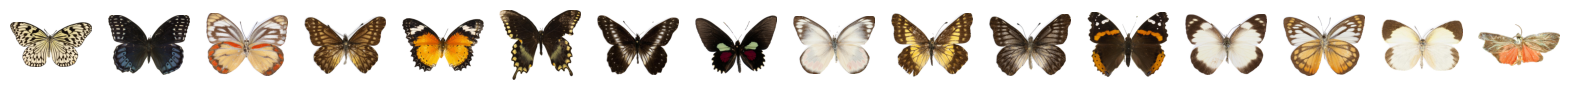

In [3]:
## --------------------------------------------------------------------------------
## Prepare dataset and data loader
## --------------------------------------------------------------------------------
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

# Load dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Visualize dataset
fig, axs = plt.subplots(1, 16, figsize=(20, 4))
for i, image in enumerate(dataset[0:160:10]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Create preprocessing pipeline
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}
dataset.set_transform(transform)

# Build data loader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=8, pin_memory=True)

print(f"=> Training samples: {len(dataset)}, training batch-size: {train_dataloader.batch_size}, {len(train_dataloader)} iters per epoch")

In [4]:
## --------------------------------------------------------------------------------
## Build a diffusion model
## --------------------------------------------------------------------------------
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # input sample size
    in_channels=3,  # input channels
    out_channels=3,  # output channels
    layers_per_block=2,  # how many ResNet layers per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [5]:
## --------------------------------------------------------------------------------
## Prepare optimizer and learning rate scheduler
## --------------------------------------------------------------------------------
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [6]:
## --------------------------------------------------------------------------------
## Customize the DDPM scheduler
## --------------------------------------------------------------------------------
# from diffusers import DDPMScheduler
import numpy as np
class MyDDPMScheduler():
    """
    Simple implementation of the DDPM scheduler.
    Borrowed from DDPMScheduler of diffusers.
    """
    def __init__(self, num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_train_timesteps = num_train_timesteps
        self.timesteps = torch.from_numpy(np.arange(0, num_train_timesteps)[::-1].copy())

        # Use linear scheduler
        self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        self.one = torch.tensor(1.0)
        self.clip_sample_range = 1.0

    def add_noise(self, original_samples, noise, timesteps):
        """Calculate noisy sample by adding noise to the original sample at a given timestep."""
        # Align the device and dtype
        device, dtype = original_samples.device, original_samples.dtype
        alphas_cumprod = self.alphas_cumprod.to(device=device, dtype=dtype)
        timesteps = timesteps.to(device=device)

        # Calculate $\sqrt{\bar{\alpha}}$
        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        # Calculate $\sqrt{1-\bar{\alpha}}$
        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        # Calculate the noisy sample; see Eq. (4) of the DDPM paper
        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

    def set_timesteps(self, num_inference_steps):
        """Set inference timesteps."""
        step_ratio = self.num_train_timesteps // num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    def _get_variance(self, t):
        """Calculate the predicted variance."""
        prev_t = t - 1
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev

        # See Eq. (7) of the DDPM paper
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t
        variance = torch.clamp(variance, min=1e-20)  # make sure it's not 0
        return variance

    def step(self, model_output, timestep, sample, generator):
        """Calculate the predicted sample of the last step and the original sample given the predicted sample and noise at current timestep."""
        t = timestep
        prev_t = t - 1

        # 1. Compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        # 2. Compute predicted original sample from predicted noise; see Eq. (15) or Eq. (4) of the DDPM paper
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 3. Clip the predicted original sample
        pred_original_sample = pred_original_sample.clamp(-self.clip_sample_range, self.clip_sample_range)

        # 4. Compute predicted mean and variance of the sample at the previous step; see Eq. (7) of the DDPM paper
        # Get mean
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample
        # Get variance
        variance = 0
        if t > 0:
            device, dtype = model_output.device, model_output.dtype
            variance_noise = torch.randn(model_output.shape, generator=generator, device=device, dtype=dtype)
            variance = (self._get_variance(t) ** 0.5) * variance_noise
        # Get the sample at the previous step
        pred_prev_sample = pred_prev_sample + variance
        
        return (pred_prev_sample, pred_original_sample)
        
noise_scheduler = MyDDPMScheduler(num_train_timesteps=1000)

Timesteps to add noise: [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950]


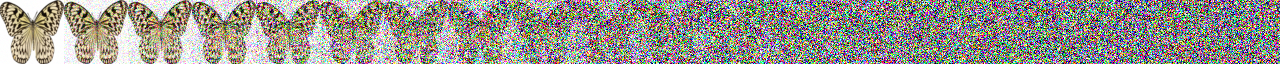

In [7]:
## --------------------------------------------------------------------------------
## Visualize the process of adding noise to clean data
## --------------------------------------------------------------------------------
import PIL
from diffusers.utils import make_image_grid

def tensor2pil(tensor):
    tensor = tensor.to("cpu")
    tensor = tensor.permute(0, 2, 3, 1)
    tensor = torch.clamp((tensor + 1) / 2 * 255, min=0, max=255)
    tensor = tensor.numpy().astype(np.uint8)
    tensor = [PIL.Image.fromarray(t) for _, t in enumerate(tensor)]
    return tensor

# Get a clean data and repeat it 20 times
clean_images = dataset[0:1]["images"][0].unsqueeze(0).repeat(20, 1, 1, 1)
noise = torch.randn(clean_images.shape, device=clean_images.device)

# Build timesteps from 0 to 999 with interval of 50
timesteps = torch.arange(start=0, end=noise_scheduler.num_train_timesteps, step=50, device=clean_images.device, dtype=torch.int64)
print("Timesteps to add noise:", timesteps.tolist())

# Add noise to clean data
noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

# Visualize noisy data
noisy_images_pil = tensor2pil(noisy_images)
samples_pil = make_image_grid(noisy_images_pil, rows=1, cols=20)
display(samples_pil)

In [8]:
## --------------------------------------------------------------------------------
## Prepare inference (sampling) pipeline
## --------------------------------------------------------------------------------
class MyDDPMPipeline():
    """
    Simple implementation of the DDPM pipeline.
    Borrowed from DDPMPipeline of diffusers.
    """
    def __init__(self, model, scheduler):
        self.model = model
        self.scheduler = scheduler
        self.device = model.device
        self.dtype = model.dtype

    @torch.no_grad()
    def __call__(self, batch_size, generator, num_inference_steps):
        image_shape = (batch_size, self.model.config.in_channels, self.model.config.sample_size, self.model.config.sample_size)
        image = torch.randn(image_shape, generator=generator, device=self.device, dtype=self.dtype)
        self.scheduler.set_timesteps(num_inference_steps)
        
        for t in self.scheduler.timesteps:
            # 1. predict noise model_output
            model_output = self.model(image, t).sample

            # 2. compute previous image: x_t -> x_t-1
            image = self.scheduler.step(model_output, t, image, generator=generator)[0]

        return image

Detected kernel version 5.4.241, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


=> Global_step: 0001/0800, loss: 1.0801, lr: 0.000001
=> Global_step: 0050/0800, loss: 0.1179, lr: 0.000050
=> Global_step: 0100/0800, loss: 0.0599, lr: 0.000100
=> Global_step: 0150/0800, loss: 0.0435, lr: 0.000099
=> Global_step: 0200/0800, loss: 0.0349, lr: 0.000095
=> Global_step: 0250/0800, loss: 0.0388, lr: 0.000089
=> Global_step: 0300/0800, loss: 0.0260, lr: 0.000081
=> Global_step: 0350/0800, loss: 0.0251, lr: 0.000072
=> Global_step: 0400/0800, loss: 0.0237, lr: 0.000061
=> Global_step: 0450/0800, loss: 0.0216, lr: 0.000050
=> Global_step: 0500/0800, loss: 0.0331, lr: 0.000039
=> Global_step: 0550/0800, loss: 0.0267, lr: 0.000028
=> Global_step: 0600/0800, loss: 0.0282, lr: 0.000019
=> Global_step: 0650/0800, loss: 0.0171, lr: 0.000011
=> Global_step: 0700/0800, loss: 0.0200, lr: 0.000005
=> Global_step: 0750/0800, loss: 0.0214, lr: 0.000001
=> Global_step: 0800/0800, loss: 0.0350, lr: 0.000000
=> Inference on epoch 1:


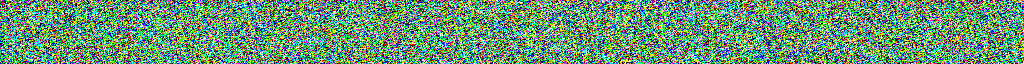

=> Inference on epoch 20:


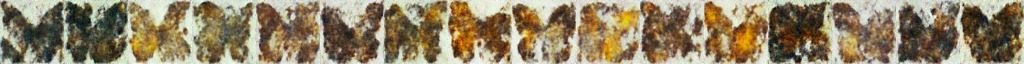

=> Inference on epoch 40:


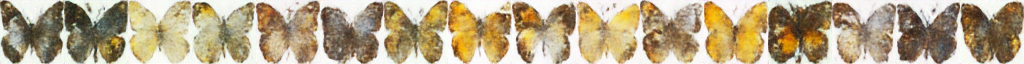

=> Inference on epoch 60:


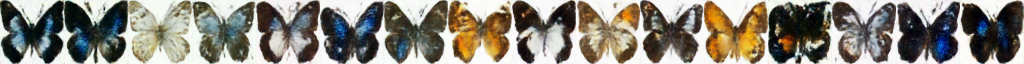

=> Inference on epoch 80:


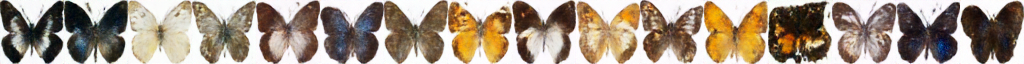

=> Inference on epoch 100:


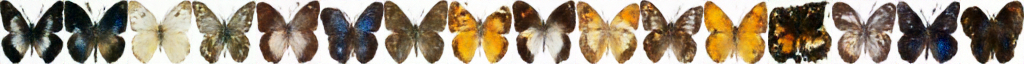

=> Finish training!


In [9]:
## --------------------------------------------------------------------------------
## Start training
## --------------------------------------------------------------------------------
from pathlib import Path
from tqdm.auto import tqdm
import torch.nn.functional as F
from accelerate import Accelerator
# from diffusers import DDPMPipeline

infer_epoch_list = list()
infer_result_list = list()
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=1)
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)
    global_step = 0
    all_steps = config.num_epochs * len(train_dataloader) 
    for epoch in range(config.num_epochs):
        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device, dtype=torch.int64)

            # Add noise to the clean images
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps).sample
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            loss_item = loss.detach().item()
            lr = lr_scheduler.get_last_lr()[0]
            global_step += 1

            if global_step == 1 or global_step % 50 == 0:
                print(f"=> Global_step: {global_step:04d}/{all_steps:04d}, loss: {loss_item:.4f}, lr: {lr:.6f}")

        # Sample images and save the model
        if accelerator.is_main_process:
            if (epoch + 1) == 1 or (epoch + 1) % config.show_image_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline = MyDDPMPipeline(model=accelerator.unwrap_model(model), scheduler=noise_scheduler)
                images = pipeline(
                    batch_size=config.eval_batch_size, 
                    generator=torch.Generator(device='cuda').manual_seed(config.seed),
                    num_inference_steps=1000)
                images = tensor2pil(images)
                image_grid = make_image_grid(images, rows=1, cols=config.eval_batch_size)

                infer_epoch_list.append(epoch + 1)
                infer_result_list.append(image_grid)

    # Display all infer results
    for epoch, result in zip(infer_epoch_list, infer_result_list):
        print(f"=> Inference on epoch {epoch}:")
        display(result)
    print("=> Finish training!")

train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)